<a href="https://colab.research.google.com/github/Inam-karim/CV-project/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls '/content/drive/MyDrive/data'

image  label


In [4]:

!7za -y x' /content/drive/MyDrive/Colab/data/image/origin.7z.001'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)



Command Line Error:
Unsupported command:
x /content/drive/MyDrive/Colab/data/image/origin.7z.001


In [ ]:
!pip install pillow

In [ ]:

!ls '/content/drive/MyDrive/data/image'

origin.7z.001  origin.7z.003  origin.7z.005  origin.7z.007
origin.7z.002  origin.7z.004  origin.7z.006  origin.7z.008


In [ ]:
!7z x '/content/drive/MyDrive/data/image/origin.7z.001'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/data/image/                                            1 file, 1048576000 bytes (1000 MiB)

Extracting archive: /content/drive/MyDrive/data/image/origin.7z.001
  0% 1 Open           --
Path = /content/drive/MyDrive/data/image/origin.7z.001
Type = Split
Physical Size = 1048576000
Volumes = 8
Total Physical Size = 8113576419
----
Path = origin.7z
Size = 8113576419
--
Path = origin.7z
Type = 7z
Physical Size = 8113576419
Headers Size = 863607
Method = LZMA:25
Solid = +
Blocks = 2

  0%      0% - origin/afraid_African_214.jpg                                    

In [5]:
path_label = "/content/drive/MyDrive/data/label/label.lst"
path_image = "/content/drive/MyDrive/Extracted Data/origin"

In [6]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Read the label information into a pandas DataFrame
df_info = pd.read_csv(path_label, sep=" ", header=None)
col_names = "image_name face_id_in_image face_box_top face_box_left face_box_right face_box_bottom face_box_cofidence expression_label".split()
df_info.columns = col_names

In [8]:
df_sel = df_info[df_info.face_box_cofidence > 30]

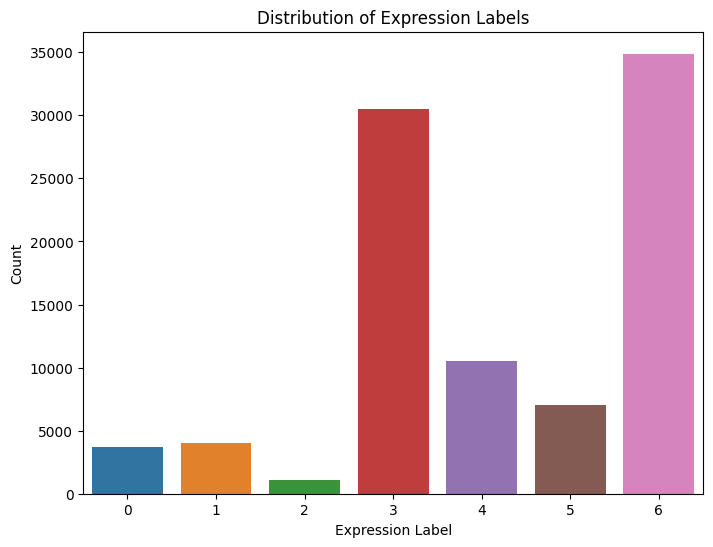

In [9]:

plt.figure(figsize=(8, 6))
sns.countplot(x='expression_label', data=df_info)
plt.xlabel('Expression Label')
plt.ylabel('Count')
plt.title('Distribution of Expression Labels')
plt.show()

In [10]:

images_list = []
labels_list = []

In [11]:
for i, row in df_sel.sample(5000).iterrows():
    img_name = row["image_name"]
    x1 = row["face_box_left"]
    x2 = row["face_box_right"]
    y1 = row["face_box_top"]
    y2 = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(path_image, img_name)
    img = cv2.imread(img_path)
    # Check if img is not None
    if img is not None:
        # Crop the image using the provided coordinates
        cropped_img = img[y1:y2, x1:x2]
    else:
        continue

    if cropped_img is not None:
        # Resize the cropped image to a fixed size (e.g., 64x64)
        resized_face = cv2.resize(cropped_img, (64, 64))
    else:
        continue

    # Normalize the image data (scaling pixel values to the range [0, 1])
    normalized_face = resized_face / 255.0
    images_list.append(normalized_face)
    labels_list.append(label)

In [21]:
X = np.array(images_list)
Y = np.array(labels_list)

In [22]:

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (61, 64, 64, 3)
Shape of Y: (61,)


In [23]:
#the data will be splitted here to tran and test set

from sklearn.model_selection import train_test_split


X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 42
Validation set size: 9
Testing set size: 10


In [24]:

from keras.utils import to_categorical

Y_train_one_hot = to_categorical(Y_train, num_classes=7)
Y_val_one_hot = to_categorical(Y_val, num_classes=7)
Y_test_one_hot = to_categorical(Y_test, num_classes=7)

In [25]:

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [26]:
first_model = Sequential()

first_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
first_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
first_model.add(MaxPooling2D(pool_size=(2, 2)))
first_model.add(Dropout(0.25))

first_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
first_model.add(MaxPooling2D(pool_size=(2, 2)))
first_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
first_model.add(MaxPooling2D(pool_size=(2, 2)))
first_model.add(Dropout(0.25))

first_model.add(Flatten())
first_model.add(Dense(1024, activation='relu'))
first_model.add(Dropout(0.5))
first_model.add(Dense(7, activation='softmax'))

In [27]:
first_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:

first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                    

In [29]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)

In [30]:
from keras.callbacks import TensorBoard

log_dir = "/content/drive/MyDrive/project/logs"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Train the model using the augmented data and TensorBoard callback
history = first_model.fit(datagen.flow(X_train, Y_train_one_hot, batch_size=32),
                            epochs=200,
                            validation_data=(X_val, Y_val_one_hot),
                            callbacks=[tensorboard_callback])

Epoch 1/200
2/2 [==============================] - 12s 710ms/step - loss: 1.8385 - accuracy: 0.0952 - val_loss: 1.2022 - val_accuracy: 0.5556
Epoch 2/200
2/2 [==============================] - 0s 61ms/step - loss: 1.9517 - accuracy: 0.4286 - val_loss: 1.5203 - val_accuracy: 0.3333
Epoch 3/200
2/2 [==============================] - 0s 62ms/step - loss: 1.4871 - accuracy: 0.3333 - val_loss: 1.6124 - val_accuracy: 0.3333
Epoch 4/200
2/2 [==============================] - 0s 53ms/step - loss: 1.5140 - accuracy: 0.3095 - val_loss: 1.5373 - val_accuracy: 0.0000e+00
Epoch 5/200
2/2 [==============================] - 0s 56ms/step - loss: 1.5328 - accuracy: 0.2381 - val_loss: 1.4165 - val_accuracy: 0.5556
Epoch 6/200
2/2 [==============================] - 0s 102ms/step - loss: 1.5424 - accuracy: 0.4286 - val_loss: 1.3540 - val_accuracy: 0.5556
Epoch 7/200
2/2 [==============================] - 0s 105ms/step - loss: 1.5108 - accuracy: 0.3571 - val_loss: 1.4036 - val_accuracy: 0.5556
Epoch 8/200


In [31]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:

Y_pred_one_hot = first_model.predict(X_test)
Y_pred = np.argmax(Y_pred_one_hot, axis=1)


1/1 [==============================] - 0s 146ms/step


In [33]:

Y_test_true = np.argmax(Y_test_one_hot, axis=1)

In [34]:

# Calculate the confusion matrix
cm = confusion_matrix(Y_test_true, Y_pred)

In [35]:
model_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

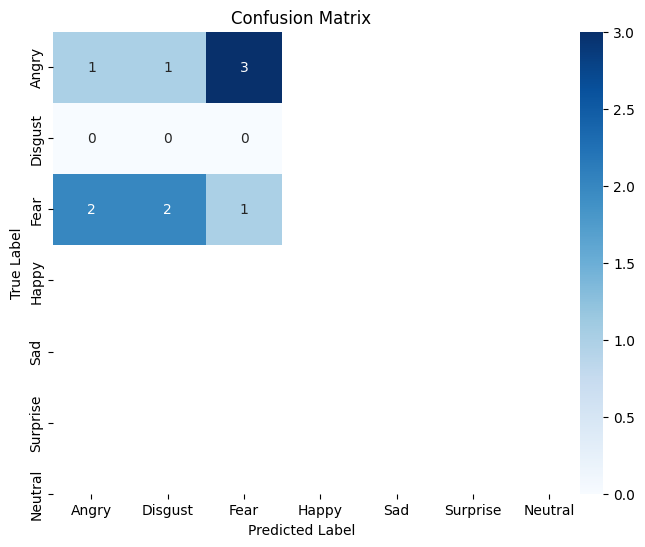

In [36]:

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_labels, yticklabels=model_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')